# End-toEnd Decel Extraction for LowCostCTG Recordings


## Configuration

### Select PC or Mac
usePc:
    
- True: Uses Windows Surface Pro
- False:  Uses Mac (Doug's  development Laptop)

In [1]:
usePc = False

### Recording set to use

use_user_2:
- False:  Uses Malawi_ctg_db     (Monica's User 1 dataset)
- True: Malawi_ctg_db_user2      (Monica's User 2 dataset)

In [2]:
use_user_2 = True

### Should we disable sustain UC test for Physionet recordings using TocoDynometer?

reason:  Baseline drift can cause false positives?

In [3]:
disable_sustained_uc_test = True

### Should limit number of recordings to display

limit_recordings:
 - None: means no limit
 - N:  limit to N recordings, where N is an integer

In [4]:
skip_recordings = 0
limit_recordings = None

###### Apply configuration to paths (update only if paths change)

In [5]:
if usePc:
    path = 'c:\Users\Dtree\Documents\ctg_db'
else:
    if use_user_2:
        path = '/Users/doug/Documents/GitHub/Malawi_ctg_db_user2'
    else:
        path = '/Users/doug/Documents/GitHub/Malawi_ctg_db'

# Imports

In [6]:
%matplotlib inline

In [7]:
import pickle
import os
from pprint import pprint
import datetime
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

from pprint import pprint
import sys

In [8]:
if usePc:
    sys.path.append('c:\Users\Dtree\Documents\GitHub\CTG\CombinedRecorder')
else:
    sys.path.append('/Users/doug/Documents/GitHub/LowCostCTG/CombinedRecorder')

In [9]:
from libLowCostCTG import selectRecordings, getRecordingsLowCostCTG
from display_recordings import displayCommon, summarizeUC
from libDecel import extractAllDecels, summarizeDecels

In [10]:
from libUC import findUC
from libFilterUC import filterArtfactsUC, PARAMS_FILTER_UC

# Config

In [11]:
from paramsDecel import FEATURE_EXTRACT_PARAMS
from display_recordings import combinedDecelColorMap

In [12]:
import warnings
warnings.filterwarnings('error')

# Code

In [13]:
def displayRecordingAll(fhr, mask, ts, uc=np.array([]), filtUC=np.array([]), tsUC=None, allUC=[],
                        sustainedUC=[],
                        allExtractorParams={}, colorMap=combinedDecelColorMap, name='',
                        plotIncr = 25, plotOverlap = 5,
                        showFull=False, showDelta=False, showVariability=False,
                        showAltBaselines=False, showIndividualDecels=False,
                        showBorderline=False):

    extractorResults = extractAllDecels(fhr, mask, ts, 
                                        allUC=allUC,
                                        allSustained=sustainedUC,
                                        allExtractorParams=FEATURE_EXTRACT_PARAMS)
    if showBorderline:
        ignore = []
    else:
        ignore = FEATURE_EXTRACT_PARAMS['allBorderline']
    
    displayCommon(extractorResults, mask, ts, uc=uc, filtUC=filtUC, tsUC=tsUC,
                  colorMap=colorMap, name=name, plotIncr=plotIncr, plotOverlap=plotOverlap,
                  showFull=showFull, showDelta=showDelta, showAltBaselines=showAltBaselines,
                  showVariability=showVariability, showIndividualDecels=showIndividualDecels,
                  ignoreArtifacts=ignore
                 )
    
    return

# Select Recordings

In [14]:
ignoreRecordings = [
    'eb3e2190-1ec4-4a3d-96b9-44e88f2ad0ff',   # deleteme temporary directory
    '64467c06-2a62-4ea0-8105-18e32a469012',
    '03e235dc-ceae-4946-b4c3-f50eb0b5bf66',
    '901a67b7-f367-42e4-a167-7b26c3b43da2'
]

selectedRecordings = []   # if empty, show all

In [15]:
subset_recordings, catalog = selectRecordings(path, selectedDate=[2018, 8, 1])

In [16]:
if len(selectedRecordings) > 0:
    subset_recordings = [x for x in subset_recordings if x in selectedRecordings]
else:
    subset_recordings = [x for x in subset_recordings if x not in ignoreRecordings]

In [17]:
subset_recordings

['91161bb3-b139-4331-8b4f-041056e74416',
 '8ca99f08-e8ad-44f1-87f6-ca242b2ad9ce',
 '5b25f3d6-1859-4307-a592-eed4f6599e75',
 'c930db20-bcc8-4e1b-a893-627988dfc624',
 'ac488e97-4d2f-4582-bcff-1fb678967c7c',
 '6e688613-e966-458b-8583-5055b2f98634',
 '135da2bb-0d36-4810-b3f8-ffbc76a43fcf',
 '05de685b-e73e-4ada-9a49-b29aa81a4d37',
 '0afeadbf-577b-45b7-8f60-70a189495752',
 '8c00a63c-9a79-4598-935a-66e2c6754404',
 '8963ebcd-cb93-49d0-bd17-e39daf1647d3',
 '7e87ad11-2020-4df9-8244-201e4b5709a7',
 '5fce3c21-9375-4f5c-b249-875fac0fd6d8',
 '3d12abdc-e504-4a9c-9ffb-3c5e739fd10e',
 '0e01d1dd-c60b-4a0b-b1f7-4b4bb0a6adb4',
 '091a24e2-e069-4b01-a11c-e534c8cd29ab',
 'f7b17628-a4f1-481a-ad6e-1daee0df3734',
 'a0f0df7e-87ad-44fd-b01a-d0ba0b6a6705',
 '906d2e3f-e391-4cbf-a324-4afdfd917574',
 '85aeb736-2a1c-4ae4-9cbe-f9caadb935f9',
 '75ad97ce-1de9-42ee-86ea-cf50acdd194c',
 '5c85bad4-6657-42e0-83ad-a7dc73a5343c',
 '57ba7581-81d0-4601-b884-9139fcd98890',
 '3331a782-3057-401c-9c6a-2e0feb7abef2',
 '0c3bdd32-4147-

# Analysis

In [18]:
if disable_sustained_uc_test:
    PARAMS_FILTER_UC['maxWidth']  = None

In [19]:
PARAMS_FILTER_UC

{'maxWidth': None,
 'minThresh': None,
 'minWidth': 35,
 'squelchFactor': 4,
 'squelchPercentile': 20}


Patient: 1
Patient:  October 9, 2018, Pt A -- 91161bb3-b139-4331-8b4f-041056e74416
Comment: G2 P1
In latent phase of labour


Recording - Duration: 10m   Date: 1539088455  e0622a82-d948-41c5-bec9-a8148c45b103


Summary of UC and Associated Periodic Decelerations
uc @  2.35m  no decel
uc @  7.10m  no decel

Totals: Early: 0.0% (0)  Late: 0.0%  (0)  of total 2


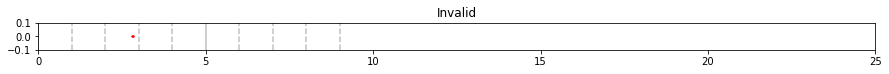

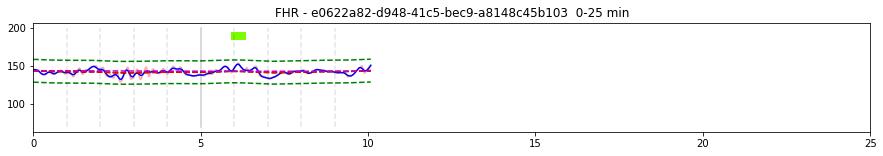

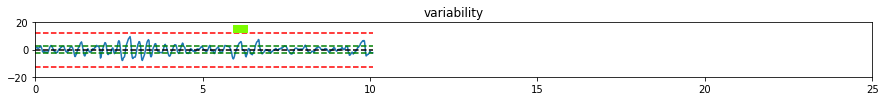

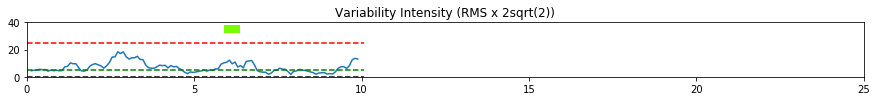

@ 6.13m : borderline_acceleration
                    10.9 bpm   dur:  13s (0.2min)   mag: 153.9 bpm   valid: 100%
                    tOnset:   7s   tRelease:   6s   span:  6.02 -  6.23 min

----------


****************************************


Patient: 2
Patient:  October 9, 2018, Pt C -- 8ca99f08-e8ad-44f1-87f6-ca242b2ad9ce
Comment: 

Recording - Duration: 11m   Date: 1539092539  a56f2004-003e-4b3d-8639-c26cf3217a12

squelchMag: 37.35
Initial:
uc @  0.4   0.2- 0.8   width:   37 mag: 28.11
uc @  3.6   2.1- 4.4   width:  135 mag: 71.94
uc @  6.3   5.2- 7.0   width:  106 mag: 103.75
uc @ 10.6  10.1-10.8   width:   44 mag: 148.10


Final:
uc @  3.6   2.1- 4.4   width:  135 mag: 71.94
uc @  6.3   5.2- 7.0   width:  106 mag: 103.75
uc @ 10.6  10.1-10.8   width:   44 mag: 148.10


Summary of UC and Associated Periodic Decelerations
uc @  3.59m  no decel
uc @  6.27m  no decel
uc @ 10.61m  no decel

Totals: Early: 0.0% (0)  Late: 0.0%  (0)  of total 3


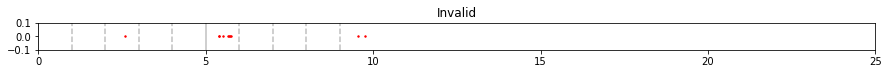

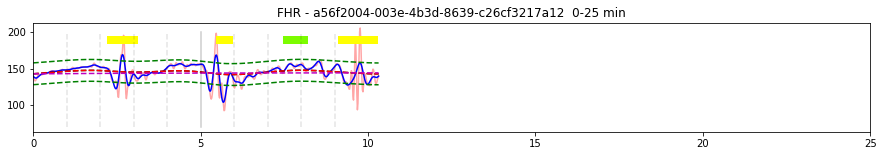

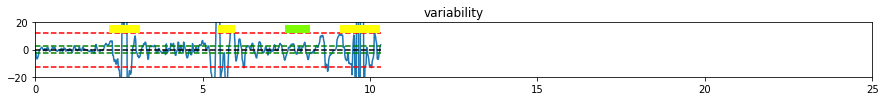

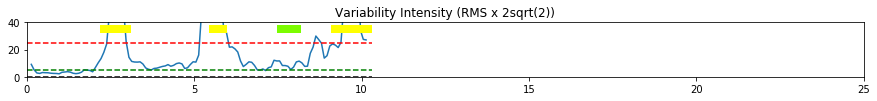

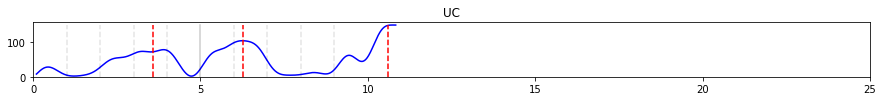

@ 2.47m : variable
                    34.7 bpm   dur:  16s (0.3min)   mag: 111.3 bpm   valid: 100%
                    tOnset:   9s   tRelease:   7s   span:  2.32 -  2.58 min
@ 2.85m : variable
                    36.6 bpm   dur:  15s (0.2min)   mag: 108.8 bpm   valid: 100%
                    tOnset:   6s   tRelease:   9s   span:  2.75 -  3.00 min
@ 5.68m : variable
                    49.9 bpm   dur:  17s (0.3min)   mag:  92.3 bpm   valid: 76%
                    tOnset:   7s   tRelease:  10s   span:  5.57 -  5.85 min
@ 7.70m : borderline_acceleration
                    10.4 bpm   dur:  30s (0.5min)   mag: 158.0 bpm   valid: 100%
                    tOnset:   7s   tRelease:  23s   span:  7.58 -  8.08 min
                    rms variability: 8 bpm
@ 9.40m : variable
                    22.8 bpm   dur:  26s (0.4min)   mag: 121.7 bpm   valid: 96%
                    tOnset:  11s   tRelease:  15s   span:  9.22 -  9.65 min
@ 9.98m : variable
                    16.3 bpm   dur:  20s (0.3

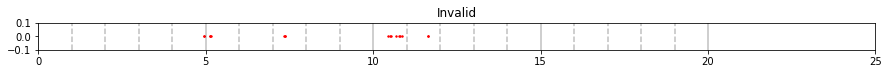

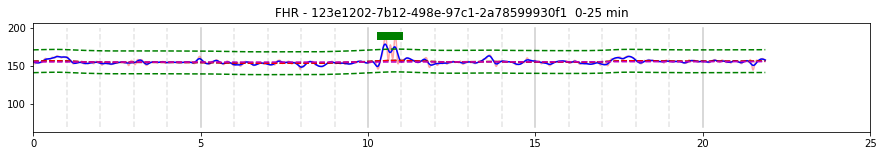

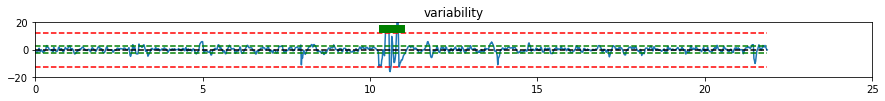

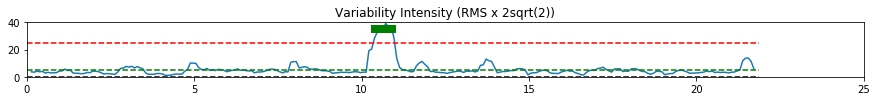

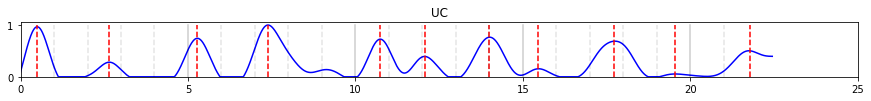

@10.52m : acceleration
                    30.4 bpm   dur:  31s (0.5min)   mag: 187.5 bpm   valid: 77%
                    tOnset:   7s   tRelease:  24s   span: 10.40 - 10.92 min
                    rms variability: 37 bpm

----------


****************************************


Patient: 4
Patient:  October 4, 2018, Pt A -- 6e688613-e966-458b-8583-5055b2f98634
Comment: 

Recording - Duration: 29m   Date: 1538640217  3761b754-70d2-4a47-a897-3519daa4632f

squelchMag: 0.00
Initial:
uc @  3.7   3.2- 4.2   width:   60 mag: 0.63
uc @  6.7   5.9- 8.4   width:  150 mag: 0.84
uc @ 10.4  10.2-10.5   width:   17 mag: 0.02
uc @ 14.5  13.9-15.5   width:  100 mag: 1.00
uc @ 17.5  16.9-25.7   width:  523 mag: 0.33
uc @ 20.2  18.3-22.1   width:  226 mag: 0.79
uc @ 21.6  18.0-23.6   width:  336 mag: 0.57
uc @ 22.9  18.2-23.6   width:  321 mag: 0.68
uc @ 25.0  24.5-25.5   width:   60 mag: 0.68
uc @ 27.5  27.0-28.1   width:   66 mag: 0.86


Final:
uc @  3.7   3.2- 4.2   width:   60 mag: 0.63
uc @  6.7   

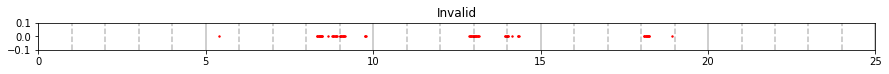

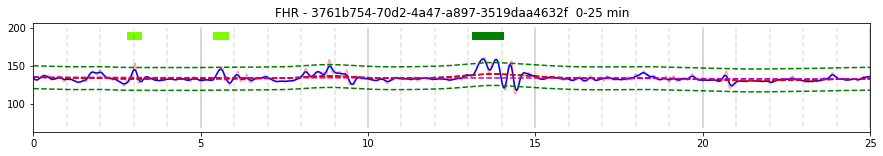

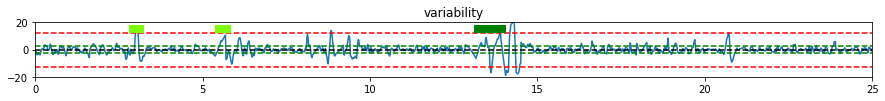

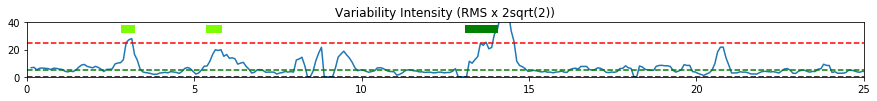

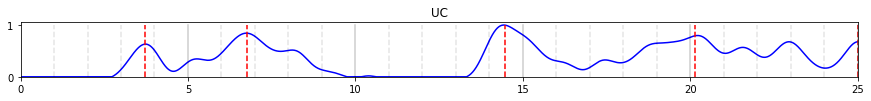

@ 3.03m : borderline_acceleration
                    20.7 bpm   dur:  11s (0.2min)   mag: 153.7 bpm   valid: 100%
                    tOnset:   6s   tRelease:   5s   span:  2.93 -  3.12 min
@ 5.65m : borderline_acceleration
                    15.3 bpm   dur:  14s (0.2min)   mag: 148.7 bpm   valid: 100%
                    tOnset:  10s   tRelease:   4s   span:  5.48 -  5.72 min
@13.47m : acceleration
                    22.0 bpm   dur:  44s (0.7min)   mag: 161.3 bpm   valid: 98%
                    tOnset:  15s   tRelease:  29s   span: 13.22 - 13.95 min
                    rms variability: 21 bpm

----------



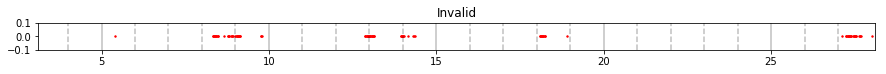

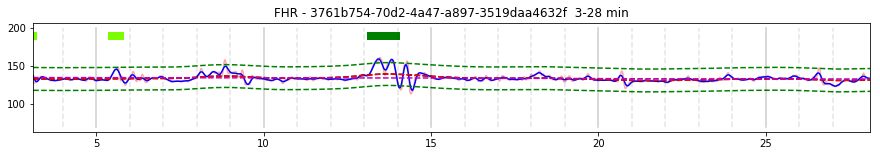

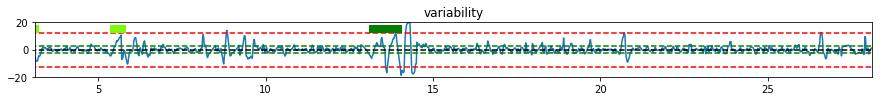

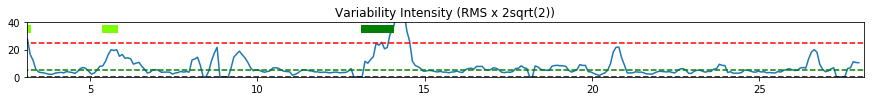

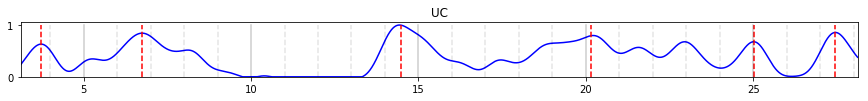

@ 5.65m : borderline_acceleration
                    15.3 bpm   dur:  14s (0.2min)   mag: 148.7 bpm   valid: 100%
                    tOnset:  10s   tRelease:   4s   span:  5.48 -  5.72 min
@13.47m : acceleration
                    22.0 bpm   dur:  44s (0.7min)   mag: 161.3 bpm   valid: 98%
                    tOnset:  15s   tRelease:  29s   span: 13.22 - 13.95 min
                    rms variability: 21 bpm

----------


****************************************


Patient: 5
Patient:  October 4, 2018, Pt B -- 135da2bb-0d36-4810-b3f8-ffbc76a43fcf
Comment: 

Recording - Duration: 21m   Date: 1538645265  ab0fb7c2-dee1-48d6-ba48-2faf23f116b3

squelchMag: 0.00
Initial:
uc @  0.5   0.5- 0.6   width:    5 mag: 0.00
uc @  3.9   3.6- 4.2   width:   40 mag: 0.01
uc @  5.9   5.6- 6.2   width:   33 mag: 0.01
uc @  7.6   7.1- 8.3   width:   73 mag: 0.53
uc @  9.0   7.0- 9.7   width:  164 mag: 0.27
uc @ 12.1  11.7-12.5   width:   51 mag: 0.03
uc @ 14.8  14.1-15.6   width:   93 mag: 0.42
uc @ 18.6 

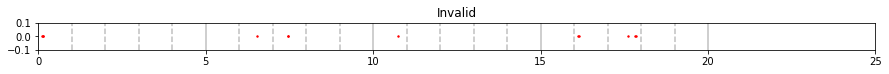

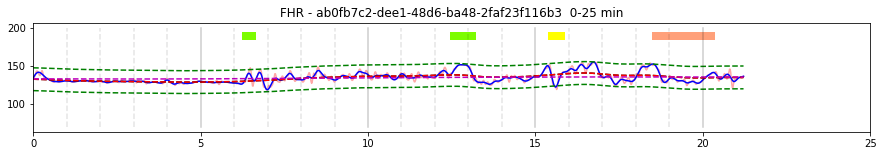

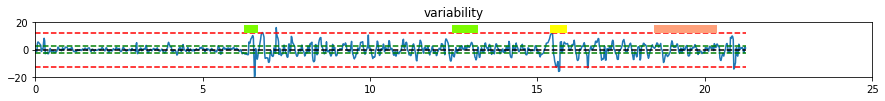

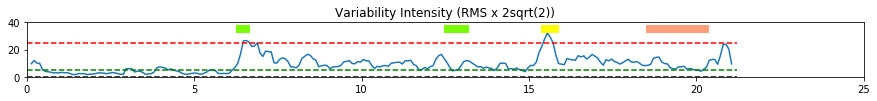

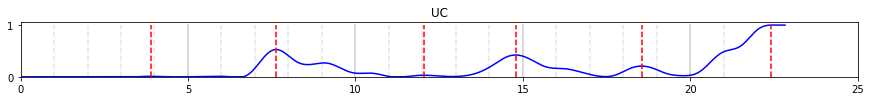

@ 6.48m : borderline_acceleration
                    17.3 bpm   dur:  10s (0.2min)   mag: 147.6 bpm   valid: 100%
                    tOnset:   7s   tRelease:   3s   span:  6.37 -  6.53 min
@12.73m : borderline_acceleration
                    13.9 bpm   dur:  32s (0.5min)   mag: 152.2 bpm   valid: 100%
                    tOnset:  10s   tRelease:  22s   span: 12.57 - 13.10 min
                    rms variability: 6 bpm
@15.60m : variable
                    19.7 bpm   dur:  17s (0.3min)   mag: 119.2 bpm   valid: 100%
                    tOnset:   7s   tRelease:  10s   span: 15.48 - 15.77 min
@19.70m : mild_late_decel
                    11.5 bpm   dur:  99s (1.6min)   mag: 127.8 bpm   valid: 100%
                    tOnset:  68s   tRelease:  31s   span: 18.60 - 20.25 min
                    time below 70% drop: 45.0 sec
                    rms variability: 7 bpm
                    UC tAcme: 18.55m   lag:  69s

----------


****************************************


Patient: 6
Patien

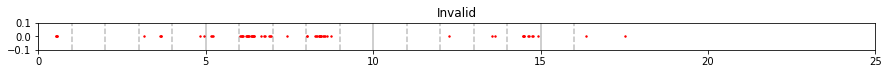

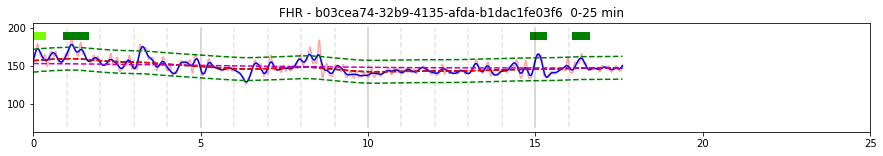

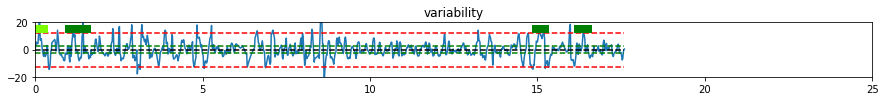

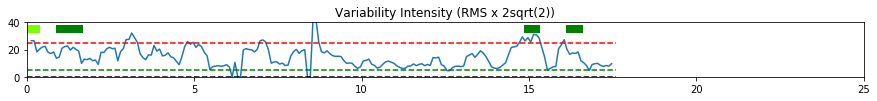

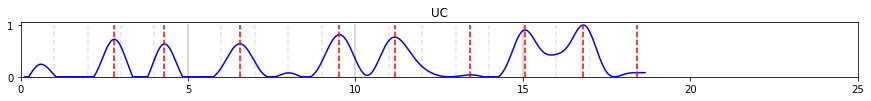

@ 0.13m : borderline_acceleration
                    21.8 bpm   dur:  14s (0.2min)   mag: 179.3 bpm   valid: 100%
                    tOnset:   6s   tRelease:   8s   span:  0.03 -  0.27 min
@ 1.15m : acceleration
                    25.9 bpm   dur:  33s (0.6min)   mag: 185.6 bpm   valid: 100%
                    tOnset:   9s   tRelease:  24s   span:  1.00 -  1.55 min
                    rms variability: 21 bpm
@15.07m : acceleration
                    19.5 bpm   dur:  15s (0.2min)   mag: 165.4 bpm   valid: 100%
                    tOnset:   6s   tRelease:   9s   span: 14.97 - 15.22 min
@16.38m : acceleration
                    19.0 bpm   dur:  17s (0.3min)   mag: 166.3 bpm   valid: 94%
                    tOnset:  10s   tRelease:   7s   span: 16.22 - 16.50 min

----------


****************************************


Patient: 7
Patient:  August 6, 2018, Pt A -- 05de685b-e73e-4ada-9a49-b29aa81a4d37
Comment: Healthy, G2 P1.
Referred to QECH due to big fundus.
Used belt for doppler, had

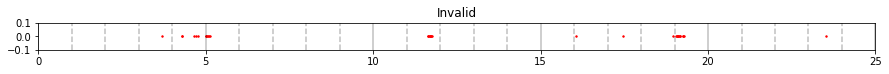

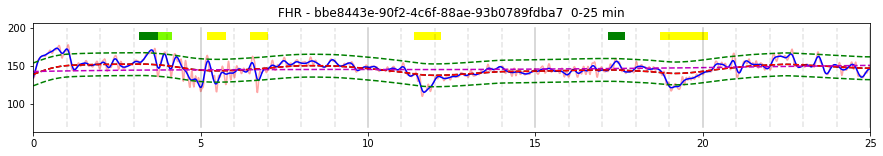

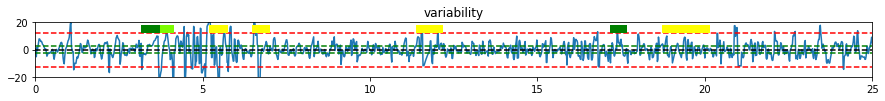

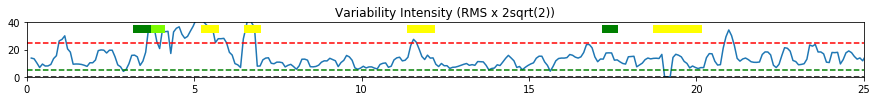

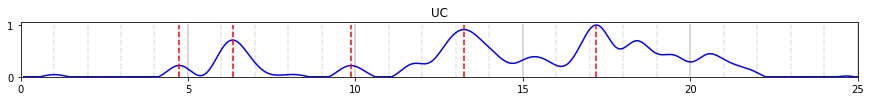

@ 3.60m : acceleration
                    18.2 bpm   dur:  23s (0.4min)   mag: 170.2 bpm   valid: 100%
                    tOnset:  19s   tRelease:   4s   span:  3.28 -  3.67 min
@ 3.93m : borderline_acceleration
                    17.7 bpm   dur:  11s (0.2min)   mag: 168.4 bpm   valid: 100%
                    tOnset:   6s   tRelease:   5s   span:  3.83 -  4.02 min
@ 5.45m : variable
                    27.7 bpm   dur:  19s (0.3min)   mag: 116.1 bpm   valid: 100%
                    tOnset:   8s   tRelease:  11s   span:  5.32 -  5.63 min
@ 6.73m : variable
                    31.0 bpm   dur:  17s (0.3min)   mag: 115.2 bpm   valid: 100%
                    tOnset:   8s   tRelease:   9s   span:  6.60 -  6.88 min
@11.68m : variable
                    28.4 bpm   dur:  35s (0.6min)   mag: 110.1 bpm   valid: 77%
                    tOnset:  12s   tRelease:  23s   span: 11.48 - 12.07 min
                    rms variability: 16 bpm
@17.40m : acceleration
                    15.2 bpm   dur:

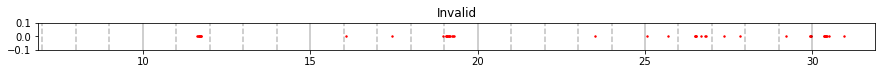

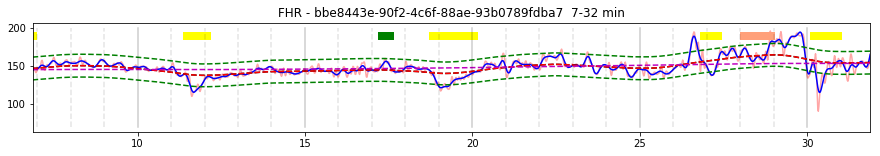

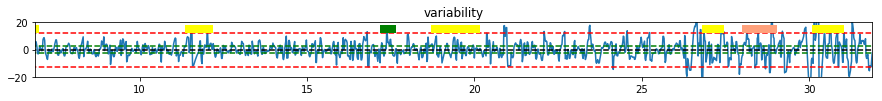

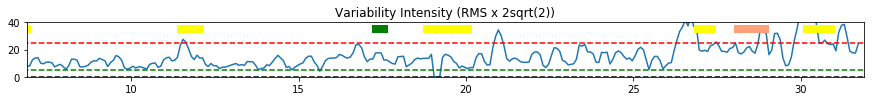

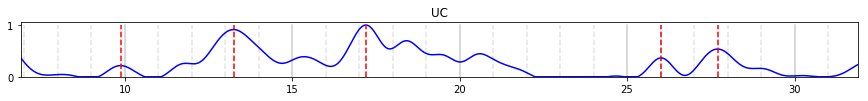

@ 6.73m : variable
                    31.0 bpm   dur:  17s (0.3min)   mag: 115.2 bpm   valid: 100%
                    tOnset:   8s   tRelease:   9s   span:  6.60 -  6.88 min
@11.68m : variable
                    28.4 bpm   dur:  35s (0.6min)   mag: 110.1 bpm   valid: 77%
                    tOnset:  12s   tRelease:  23s   span: 11.48 - 12.07 min
                    rms variability: 16 bpm
@17.40m : acceleration
                    15.2 bpm   dur:  15s (0.2min)   mag: 160.1 bpm   valid: 93%
                    tOnset:   6s   tRelease:   9s   span: 17.30 - 17.55 min
@19.07m : variable
                    23.2 bpm   dur:  73s (1.2min)   mag: 117.2 bpm   valid: 84%
                    tOnset:  14s   tRelease:  59s   span: 18.83 - 20.05 min
                    rms variability: 13 bpm
@27.17m : variable
                    20.0 bpm   dur:  25s (0.4min)   mag: 137.2 bpm   valid: 100%
                    tOnset:  14s   tRelease:  11s   span: 26.93 - 27.35 min
@28.53m : mild_late_decel
     

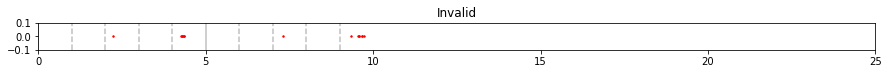

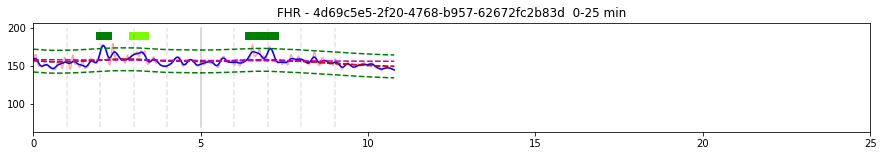

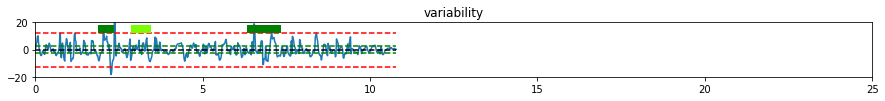

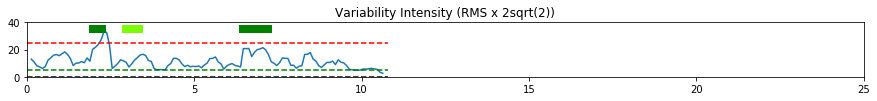

@ 2.07m : acceleration
                    20.0 bpm   dur:  15s (0.2min)   mag: 178.2 bpm   valid: 100%
                    tOnset:   5s   tRelease:  10s   span:  1.98 -  2.23 min
@ 3.22m : borderline_acceleration
                    11.4 bpm   dur:  23s (0.4min)   mag: 170.0 bpm   valid: 100%
                    tOnset:  15s   tRelease:   8s   span:  2.97 -  3.35 min
@ 6.55m : acceleration
                    19.9 bpm   dur:  22s (0.4min)   mag: 177.9 bpm   valid: 100%
                    tOnset:   6s   tRelease:  16s   span:  6.45 -  6.82 min
@ 7.07m : acceleration
                    17.4 bpm   dur:  15s (0.2min)   mag: 175.4 bpm   valid: 100%
                    tOnset:   6s   tRelease:   9s   span:  6.97 -  7.22 min

----------


****************************************


Patient: 9
Patient:  August 15 2018, Pt E -- 5fce3c21-9375-4f5c-b249-875fac0fd6d8
Comment: G1 P0
Induced labour with misoprostol
Admitted with Intrauterine Growth Restriction
Small fundus
Minimal maternal movemen

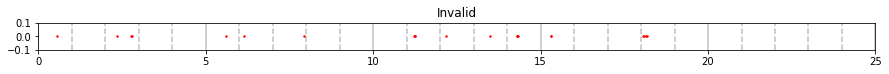

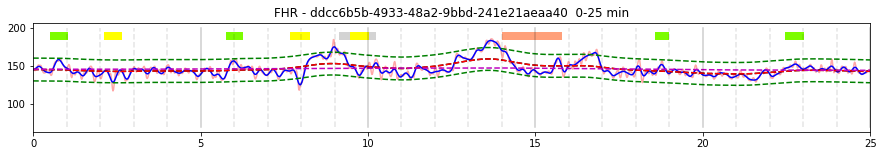

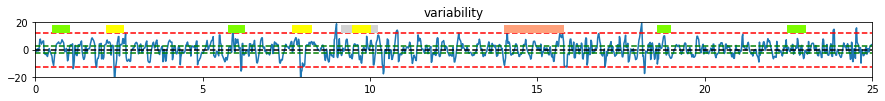

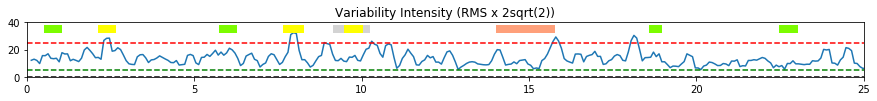

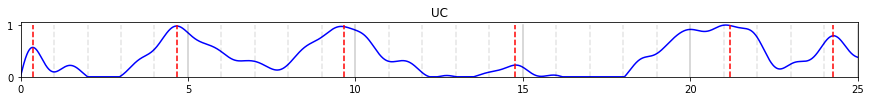

@ 0.82m : borderline_acceleration
                    14.0 bpm   dur:  18s (0.3min)   mag: 159.2 bpm   valid: 100%
                    tOnset:  11s   tRelease:   7s   span:  0.63 -  0.93 min
@ 2.38m : variable
                    25.7 bpm   dur:  18s (0.3min)   mag: 117.3 bpm   valid: 94%
                    tOnset:   9s   tRelease:   9s   span:  2.23 -  2.53 min
@ 6.03m : borderline_acceleration
                    14.1 bpm   dur:  17s (0.3min)   mag: 158.7 bpm   valid: 94%
                    tOnset:  10s   tRelease:   7s   span:  5.87 -  6.15 min
@ 7.97m : variable
                    30.5 bpm   dur:  22s (0.4min)   mag: 118.3 bpm   valid: 95%
                    tOnset:  11s   tRelease:  11s   span:  7.78 -  8.15 min
@ 9.72m : shallow_early_decel
                     9.2 bpm   dur:  52s (0.9min)   mag: 141.5 bpm   valid: 100%
                    tOnset:  29s   tRelease:  23s   span:  9.25 - 10.12 min
                    time below 70% drop: 17.0 sec
                    rms variabil

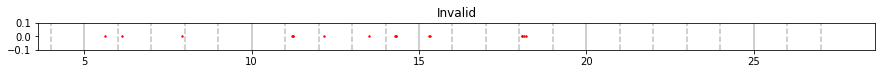

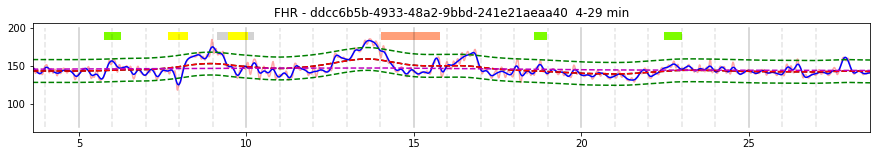

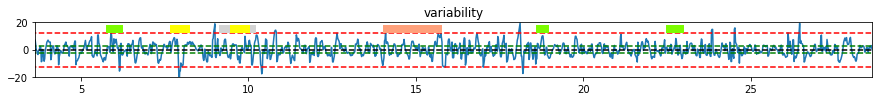

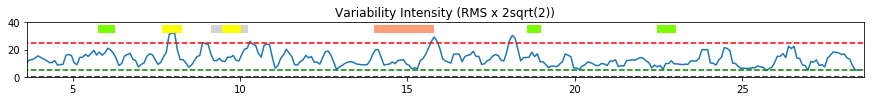

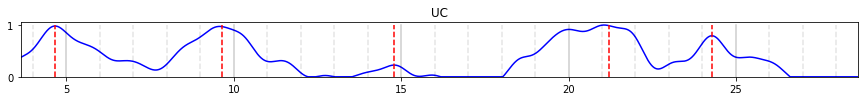

@ 6.03m : borderline_acceleration
                    14.1 bpm   dur:  17s (0.3min)   mag: 158.7 bpm   valid: 94%
                    tOnset:  10s   tRelease:   7s   span:  5.87 -  6.15 min
@ 7.97m : variable
                    30.5 bpm   dur:  22s (0.4min)   mag: 118.3 bpm   valid: 95%
                    tOnset:  11s   tRelease:  11s   span:  7.78 -  8.15 min
@ 9.72m : shallow_early_decel
                     9.2 bpm   dur:  52s (0.9min)   mag: 141.5 bpm   valid: 100%
                    tOnset:  29s   tRelease:  23s   span:  9.25 - 10.12 min
                    time below 70% drop: 17.0 sec
                    rms variability: 13 bpm
                    UC tAcme:  9.65m   lag:   4s
@ 9.75m : variable
                    16.2 bpm   dur:  20s (0.3min)   mag: 134.0 bpm   valid: 100%
                    tOnset:  10s   tRelease:  10s   span:  9.58 -  9.92 min
@15.20m : mild_late_decel
                    13.0 bpm   dur:  92s (1.5min)   mag: 139.9 bpm   valid: 95%
                    tOn

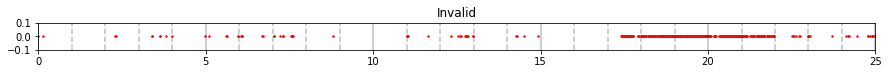

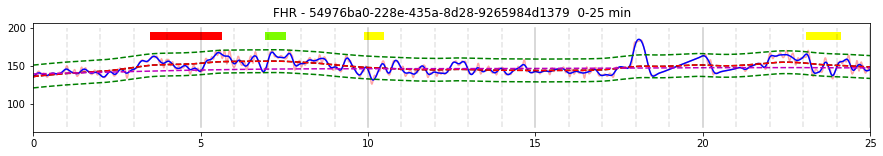

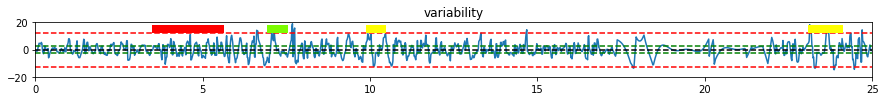

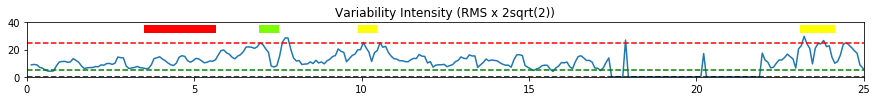

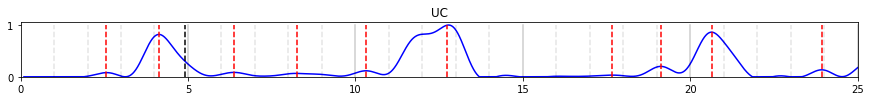

@ 4.90m : late_decel
                    15.5 bpm   dur: 114s (1.9min)   mag: 144.9 bpm   valid: 95%
                    tOnset:  76s   tRelease:  38s   span:  3.62 -  5.52 min
                    time below 70% drop: 49.0 sec
                    rms variability: 12 bpm
                    UC tAcme:  4.14m   lag:  45s
@ 7.13m : borderline_acceleration
                    13.5 bpm   dur:  22s (0.4min)   mag: 170.0 bpm   valid: 82%
                    tOnset:   5s   tRelease:  17s   span:  7.05 -  7.42 min
@10.15m : variable
                    21.7 bpm   dur:  21s (0.3min)   mag: 126.1 bpm   valid: 100%
                    tOnset:   9s   tRelease:  12s   span: 10.00 - 10.35 min
@23.37m : variable
                    16.5 bpm   dur:  26s (0.4min)   mag: 136.3 bpm   valid: 100%
                    tOnset:  10s   tRelease:  16s   span: 23.20 - 23.63 min
@23.88m : variable
                    17.8 bpm   dur:  17s (0.3min)   mag: 133.2 bpm   valid: 100%
                    tOnset:   9s   tRe

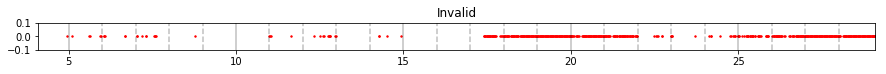

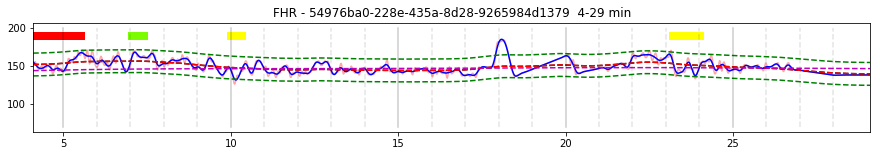

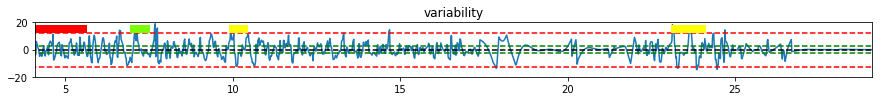

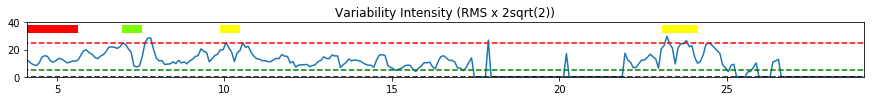

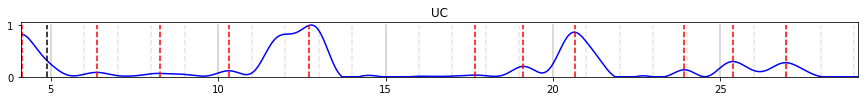

@ 4.90m : late_decel
                    15.5 bpm   dur: 114s (1.9min)   mag: 144.9 bpm   valid: 95%
                    tOnset:  76s   tRelease:  38s   span:  3.62 -  5.52 min
                    time below 70% drop: 49.0 sec
                    rms variability: 12 bpm
                    UC tAcme:  4.14m   lag:  45s
@ 7.13m : borderline_acceleration
                    13.5 bpm   dur:  22s (0.4min)   mag: 170.0 bpm   valid: 82%
                    tOnset:   5s   tRelease:  17s   span:  7.05 -  7.42 min
@10.15m : variable
                    21.7 bpm   dur:  21s (0.3min)   mag: 126.1 bpm   valid: 100%
                    tOnset:   9s   tRelease:  12s   span: 10.00 - 10.35 min
@23.37m : variable
                    16.5 bpm   dur:  26s (0.4min)   mag: 136.3 bpm   valid: 100%
                    tOnset:  10s   tRelease:  16s   span: 23.20 - 23.63 min
@23.88m : variable
                    17.8 bpm   dur:  17s (0.3min)   mag: 133.2 bpm   valid: 100%
                    tOnset:   9s   tRe

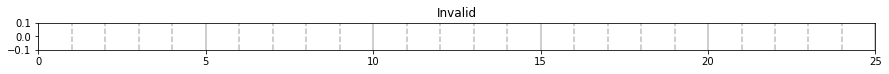

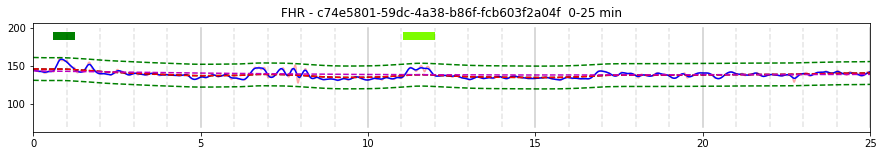

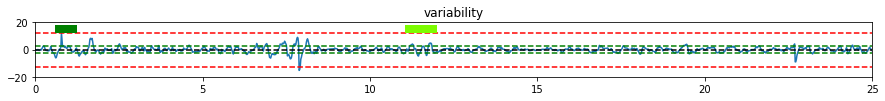

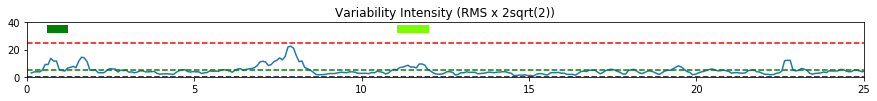

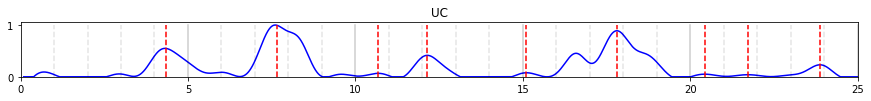

@ 0.80m : acceleration
                    15.3 bpm   dur:  24s (0.4min)   mag: 161.4 bpm   valid: 100%
                    tOnset:   5s   tRelease:  19s   span:  0.72 -  1.12 min
@11.58m : borderline_acceleration
                    11.6 bpm   dur:  43s (0.7min)   mag: 150.2 bpm   valid: 100%
                    tOnset:  25s   tRelease:  18s   span: 11.17 - 11.88 min
                    rms variability: 8 bpm

----------



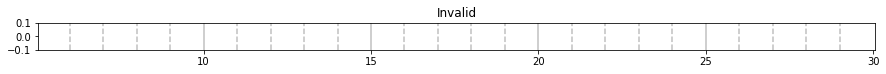

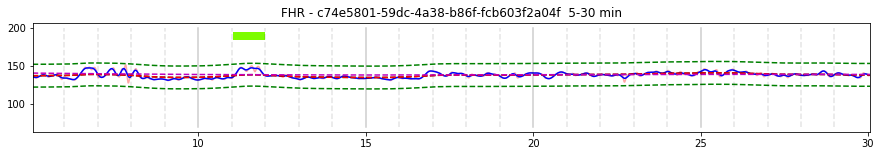

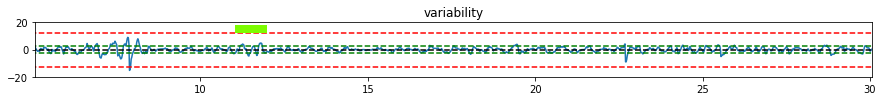

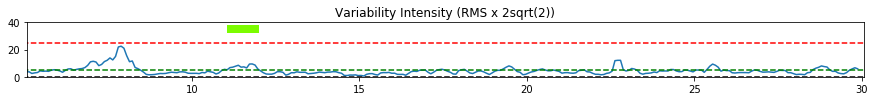

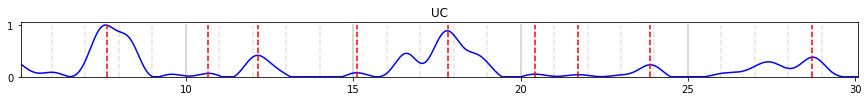

@11.58m : borderline_acceleration
                    11.6 bpm   dur:  43s (0.7min)   mag: 150.2 bpm   valid: 100%
                    tOnset:  25s   tRelease:  18s   span: 11.17 - 11.88 min
                    rms variability: 8 bpm

----------


****************************************


Patient: 12
Patient:  August 9, 2018, Pt B -- f7b17628-a4f1-481a-ad6e-1daee0df3734
Comment: G2 P1
1 previous scar
Cervix 3cm 2 mild UC on file.
Membranes intact
UC at  6 to 8 mins plus FM at the end of UC, 14 to 15.8 plus FM before onset of UC and throughout.

Recording - Duration: 16m   Date: 1533803003  42009ac5-cb34-4ef2-8610-c01bda4368c5

squelchMag: 0.00
Initial:
uc @  1.7   1.3- 2.2   width:   51 mag: 0.41
uc @  3.7   3.4- 4.0   width:   35 mag: 0.17
uc @  7.0   6.5- 8.6   width:  127 mag: 1.00
uc @ 10.8  10.2-11.4   width:   70 mag: 0.85
uc @ 12.2   9.9-16.0   width:  365 mag: 0.48
uc @ 14.9  13.2-16.0   width:  167 mag: 0.80


Final:
uc @  1.7   1.3- 2.2   width:   51 mag: 0.41
uc @  7.0   6.

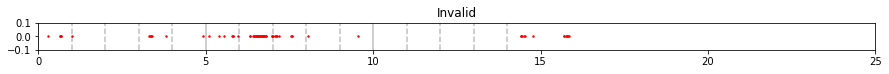

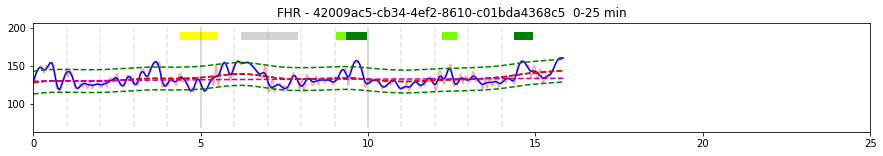

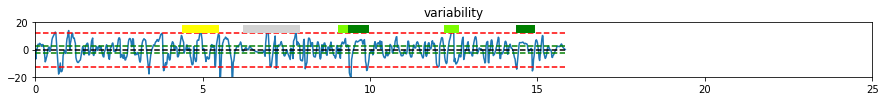

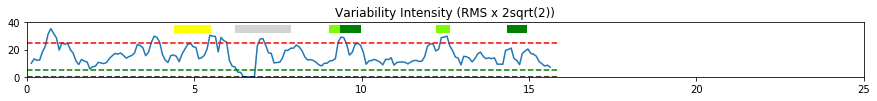

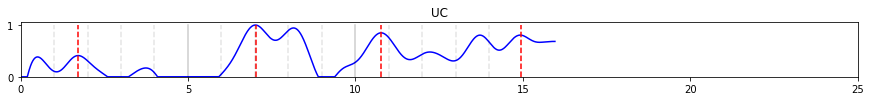

@ 4.72m : variable
                    18.7 bpm   dur:  23s (0.4min)   mag: 115.2 bpm   valid: 100%
                    tOnset:  12s   tRelease:  11s   span:  4.52 -  4.90 min
@ 5.12m : variable
                    18.4 bpm   dur:  25s (0.4min)   mag: 116.8 bpm   valid: 96%
                    tOnset:  10s   tRelease:  15s   span:  4.95 -  5.37 min
@ 7.32m : shallow_early_decel
                     9.9 bpm   dur:  87s (1.5min)   mag: 121.7 bpm   valid: 59%
                    tOnset:  62s   tRelease:  25s   span:  6.33 -  7.78 min
                    time below 70% drop: 23.0 sec
                    rms variability: 17 bpm
                    UC tAcme:  7.02m   lag:  18s
@ 9.32m : borderline_acceleration
                    11.7 bpm   dur:  12s (0.2min)   mag: 146.1 bpm   valid: 100%
                    tOnset:  10s   tRelease:   2s   span:  9.15 -  9.35 min
@ 9.60m : acceleration
                    21.5 bpm   dur:  23s (0.4min)   mag: 155.5 bpm   valid: 96%
                    tOnset

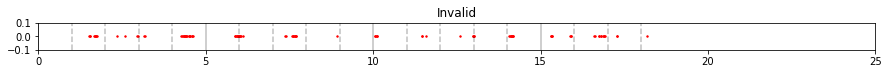

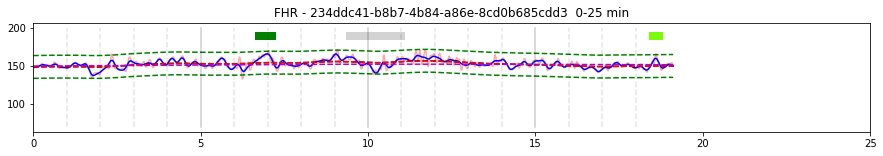

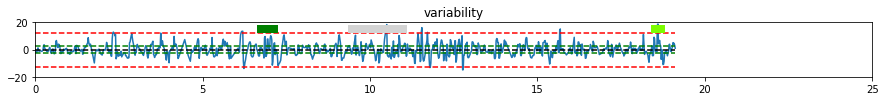

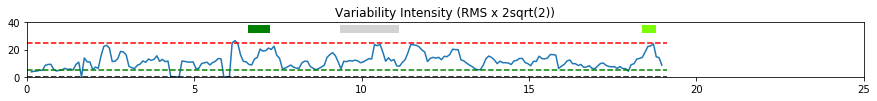

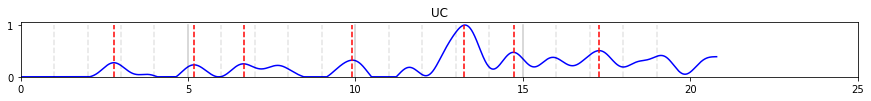

@ 7.03m : acceleration
                    15.8 bpm   dur:  24s (0.4min)   mag: 170.2 bpm   valid: 100%
                    tOnset:  18s   tRelease:   6s   span:  6.73 -  7.13 min
@10.22m : shallow_early_decel
                    13.5 bpm   dur:  92s (1.5min)   mag: 145.3 bpm   valid: 95%
                    tOnset:  45s   tRelease:  47s   span:  9.47 - 11.00 min
                    time below 70% drop: 27.0 sec
                    rms variability: 12 bpm
                    UC tAcme:  9.90m   lag:  19s
@18.60m : borderline_acceleration
                    16.3 bpm   dur:  11s (0.2min)   mag: 166.4 bpm   valid: 100%
                    tOnset:   6s   tRelease:   5s   span: 18.50 - 18.68 min

----------


****************************************


Patient: 14
Patient:  August 9, 2018, Pt A -- 906d2e3f-e391-4cbf-a324-4afdfd917574
Comment: G3 P2
37 wks GA
2 previous scar in latent phase of labour.
2 moderate UC on file, membranes intact.
Scheduled for CS.
UC at 8 to10, 12-13, 16.5 to20.5 

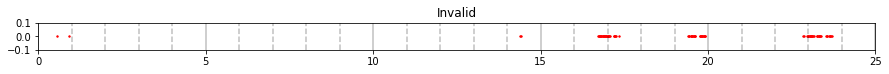

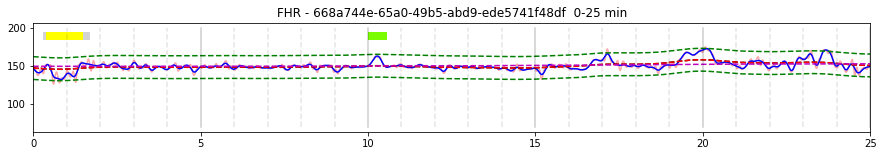

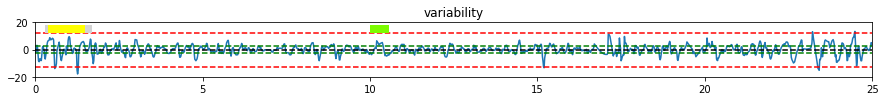

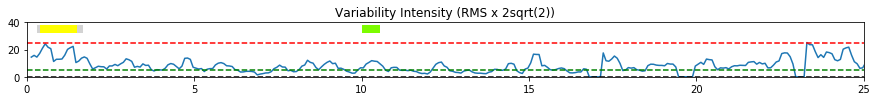

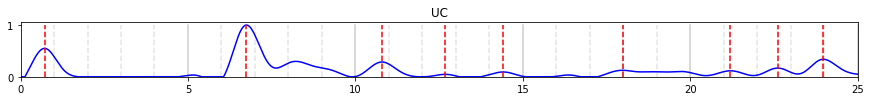

@ 0.83m : shallow_early_decel
                    13.5 bpm   dur:  69s (1.1min)   mag: 133.5 bpm   valid: 97%
                    tOnset:  24s   tRelease:  45s   span:  0.42 -  1.57 min
                    time below 70% drop: 25.0 sec
                    rms variability: 18 bpm
                    UC tAcme:  0.72m   lag:   7s
@ 0.83m : variable
                    18.1 bpm   dur:  52s (0.9min)   mag: 127.7 bpm   valid: 96%
                    tOnset:  20s   tRelease:  32s   span:  0.50 -  1.37 min
                    rms variability: 18 bpm
@10.23m : borderline_acceleration
                    12.6 bpm   dur:  19s (0.3min)   mag: 163.1 bpm   valid: 100%
                    tOnset:   7s   tRelease:  12s   span: 10.12 - 10.43 min

----------



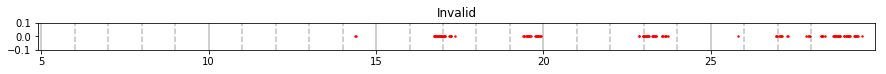

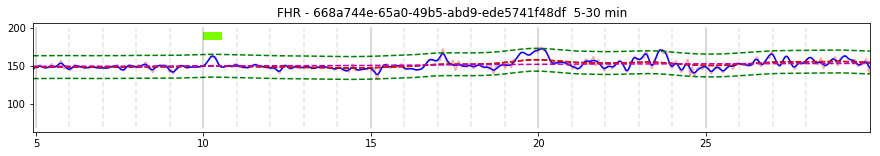

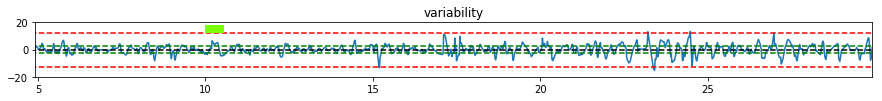

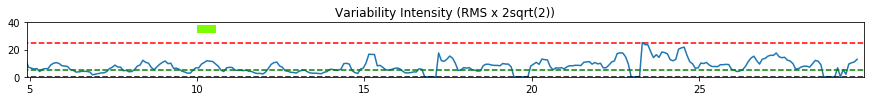

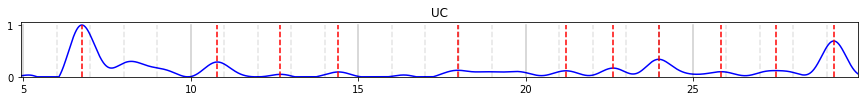

@10.23m : borderline_acceleration
                    12.6 bpm   dur:  19s (0.3min)   mag: 163.1 bpm   valid: 100%
                    tOnset:   7s   tRelease:  12s   span: 10.12 - 10.43 min

----------


****************************************


Patient: 15
Patient:  August 6, 2018, Pt C -- 85aeb736-2a1c-4ae4-9cbe-f9caadb935f9
Comment: Healthy, G2 P1. 38 wks GA.
Membranes intact. 
Labour induction with oxytocin.
Maternal movement ++.
Left unattended for 20mins to set up on another client.

Recording - Duration: 33m   Date: 1533550402  a8301858-6d48-4c7e-bfe9-5348bf463751

squelchMag: 0.00
Initial:
uc @  1.0   0.7- 1.3   width:   40 mag: 0.33
uc @  4.4   3.9- 6.2   width:  139 mag: 0.82
uc @  7.1   6.5- 7.5   width:   61 mag: 0.71
uc @  9.3   8.5- 9.9   width:   83 mag: 1.00
uc @ 10.5   8.3-10.9   width:  156 mag: 0.38
uc @ 12.2  11.8-12.6   width:   45 mag: 0.57
uc @ 13.7  13.4-14.0   width:   36 mag: 0.29
uc @ 15.3  15.2-15.4   width:   13 mag: 0.02
uc @ 18.2  17.9-18.6   width:   4

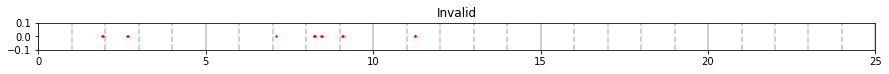

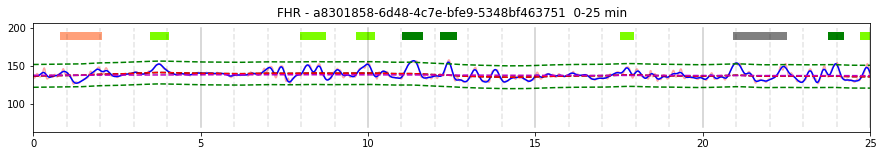

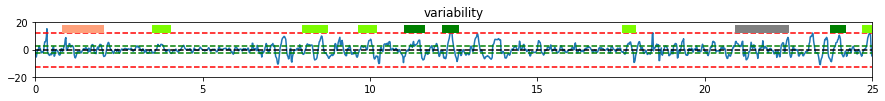

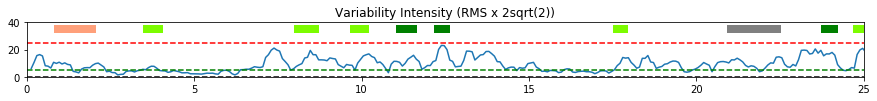

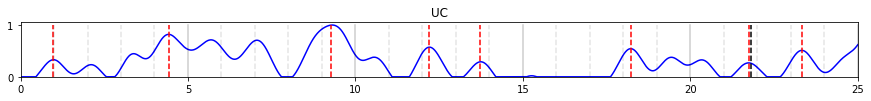

@ 1.35m : mild_late_decel
                    13.7 bpm   dur:  61s (1.0min)   mag: 128.0 bpm   valid: 97%
                    tOnset:  26s   tRelease:  35s   span:  0.92 -  1.93 min
                    time below 70% drop: 20.0 sec
                    rms variability: 7 bpm
                    UC tAcme:  0.98m   lag:  22s
@ 3.78m : borderline_acceleration
                    11.6 bpm   dur:  20s (0.3min)   mag: 153.1 bpm   valid: 100%
                    tOnset:  11s   tRelease:   9s   span:  3.60 -  3.93 min
@ 8.25m : borderline_acceleration
                    10.8 bpm   dur:  12s (0.2min)   mag: 151.6 bpm   valid: 75%
                    tOnset:   9s   tRelease:   3s   span:  8.10 -  8.30 min
@ 8.55m : borderline_acceleration
                    12.1 bpm   dur:  10s (0.2min)   mag: 152.8 bpm   valid: 80%
                    tOnset:   6s   tRelease:   4s   span:  8.45 -  8.62 min
@10.00m : borderline_acceleration
                    13.7 bpm   dur:  20s (0.3min)   mag: 154.5 bpm   va

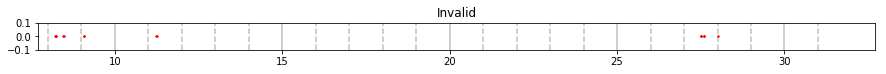

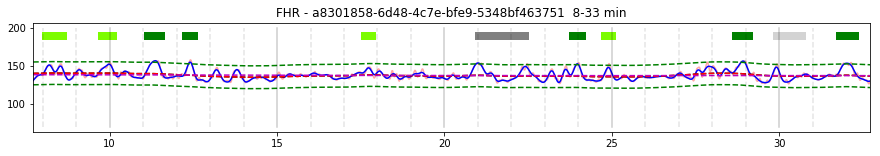

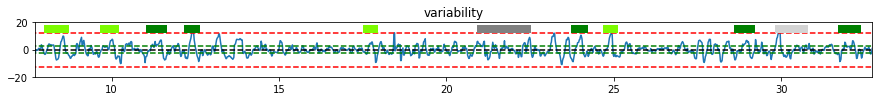

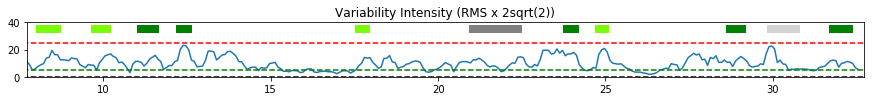

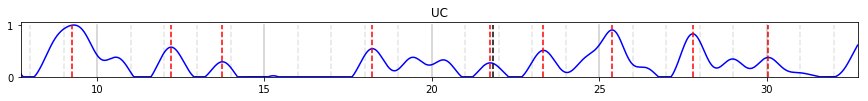

@ 8.25m : borderline_acceleration
                    10.8 bpm   dur:  12s (0.2min)   mag: 151.6 bpm   valid: 75%
                    tOnset:   9s   tRelease:   3s   span:  8.10 -  8.30 min
@ 8.55m : borderline_acceleration
                    12.1 bpm   dur:  10s (0.2min)   mag: 152.8 bpm   valid: 80%
                    tOnset:   6s   tRelease:   4s   span:  8.45 -  8.62 min
@10.00m : borderline_acceleration
                    13.7 bpm   dur:  20s (0.3min)   mag: 154.5 bpm   valid: 100%
                    tOnset:  14s   tRelease:   6s   span:  9.77 - 10.10 min
@11.43m : acceleration
                    16.5 bpm   dur:  24s (0.4min)   mag: 156.4 bpm   valid: 92%
                    tOnset:  18s   tRelease:   6s   span: 11.13 - 11.53 min
@12.42m : acceleration
                    20.2 bpm   dur:  15s (0.2min)   mag: 158.2 bpm   valid: 100%
                    tOnset:   8s   tRelease:   7s   span: 12.28 - 12.53 min
@17.75m : borderline_acceleration
                    10.5 bpm   dur: 

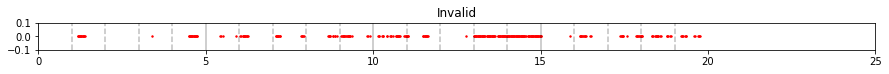

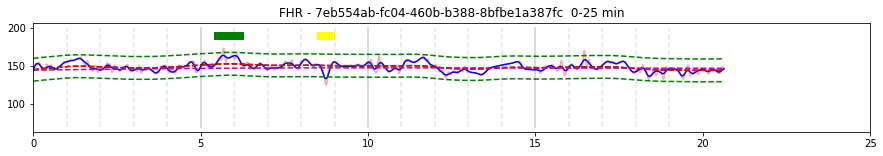

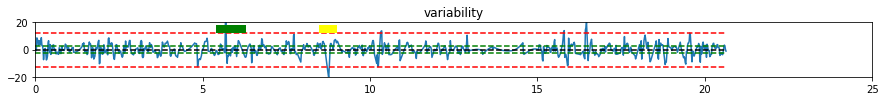

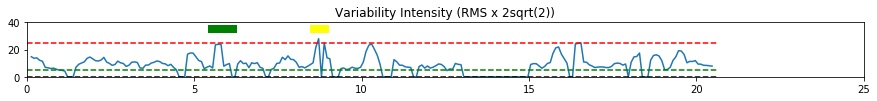

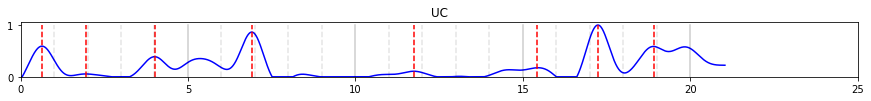

@ 5.68m : acceleration
                    20.6 bpm   dur:  38s (0.6min)   mag: 173.5 bpm   valid: 82%
                    tOnset:   9s   tRelease:  29s   span:  5.53 -  6.17 min
                    rms variability: 10 bpm
@ 8.75m : variable
                    26.0 bpm   dur:  19s (0.3min)   mag: 124.6 bpm   valid: 53%
                    tOnset:  10s   tRelease:   9s   span:  8.58 -  8.90 min

----------


****************************************


Patient: 17
Patient:  August 9, 2018, Pt E -- 5c85bad4-6657-42e0-83ad-a7dc73a5343c
Comment: G2 P1.
1 previous CS scar, scheduled for CS.
2 moderate UC on file.
Cervix 4cm Descent 4/5.
Client refused to use belt for doppler, had to hold it in place manually.
Tocopatch did not show UC despite troubleshooting, probably battery died.
Woman moved a lot during recording.
She went for CS after finishing the recording.

Recording - Duration: 11m   Date: 1533818621  901a67b7-f367-42e4-a167-7b26c3b43da2



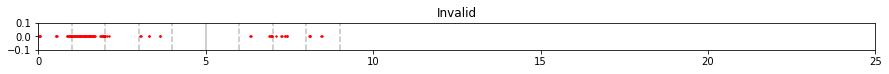

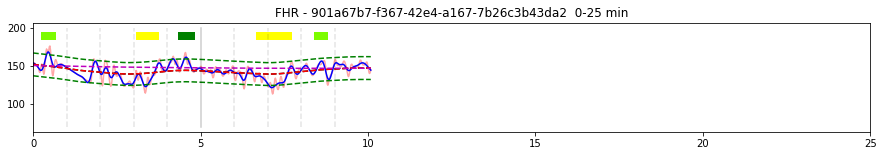

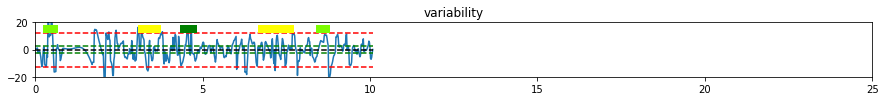

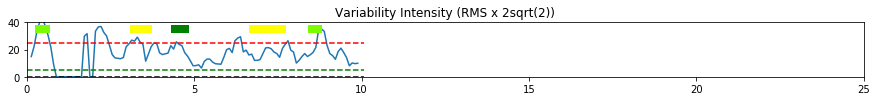

@ 0.50m : borderline_acceleration
                    26.6 bpm   dur:  13s (0.2min)   mag: 176.3 bpm   valid: 77%
                    tOnset:   9s   tRelease:   4s   span:  0.35 -  0.57 min
@ 3.35m : variable
                    26.1 bpm   dur:  26s (0.4min)   mag: 114.3 bpm   valid: 88%
                    tOnset:   9s   tRelease:  17s   span:  3.20 -  3.63 min
@ 4.55m : acceleration
                    23.4 bpm   dur:  17s (0.3min)   mag: 167.8 bpm   valid: 100%
                    tOnset:   7s   tRelease:  10s   span:  4.43 -  4.72 min
@ 7.13m : variable
                    26.3 bpm   dur:  51s (0.8min)   mag: 113.2 bpm   valid: 75%
                    tOnset:  22s   tRelease:  29s   span:  6.77 -  7.62 min
                    rms variability: 17 bpm
@ 8.68m : borderline_acceleration
                    11.8 bpm   dur:  11s (0.2min)   mag: 157.2 bpm   valid: 100%
                    tOnset:  10s   tRelease:   1s   span:  8.52 -  8.70 min

----------


*******************************

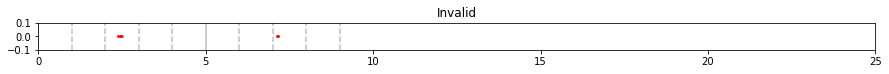

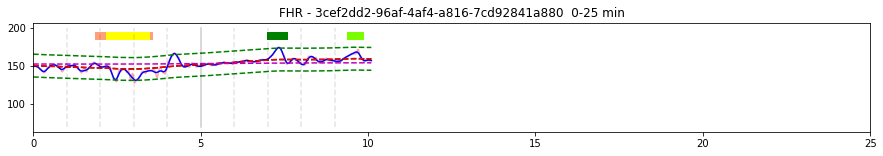

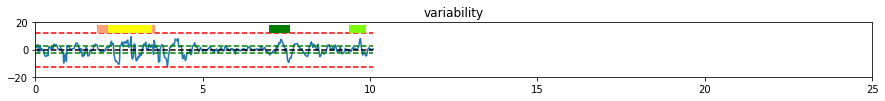

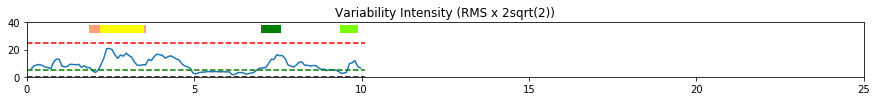

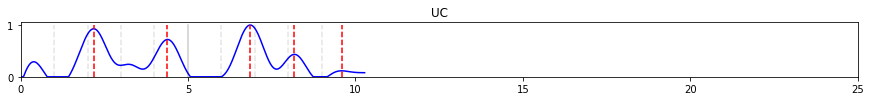

@ 3.07m : mild_late_decel
                    10.6 bpm   dur:  89s (1.5min)   mag: 133.6 bpm   valid: 93%
                    tOnset:  66s   tRelease:  23s   span:  1.97 -  3.45 min
                    time below 70% drop: 16.0 sec
                    rms variability: 14 bpm
                    UC tAcme:  2.19m   lag:  53s
@ 2.45m : variable
                    17.2 bpm   dur:  20s (0.3min)   mag: 129.3 bpm   valid: 70%
                    tOnset:   9s   tRelease:  11s   span:  2.30 -  2.63 min
@ 3.07m : variable
                    18.0 bpm   dur:  37s (0.6min)   mag: 128.2 bpm   valid: 100%
                    tOnset:  18s   tRelease:  19s   span:  2.77 -  3.38 min
                    rms variability: 15 bpm
@ 7.35m : acceleration
                    16.3 bpm   dur:  22s (0.4min)   mag: 174.9 bpm   valid: 82%
                    tOnset:  14s   tRelease:   8s   span:  7.12 -  7.48 min
@ 9.70m : borderline_acceleration
                    12.2 bpm   dur:  17s (0.3min)   mag: 171.9 bpm 

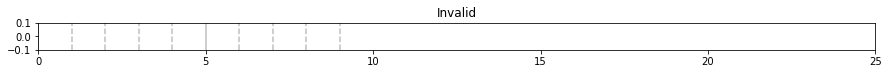

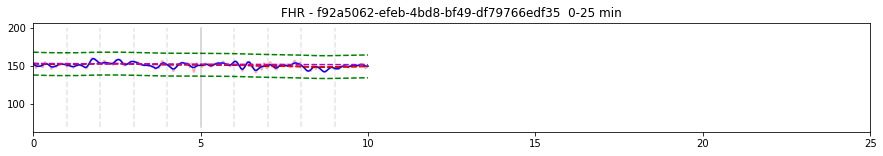

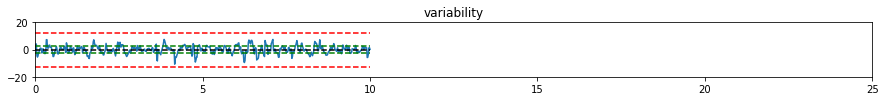

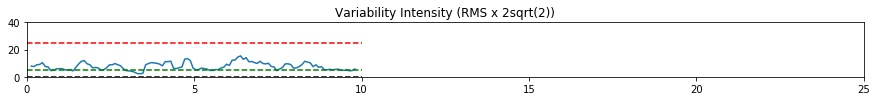

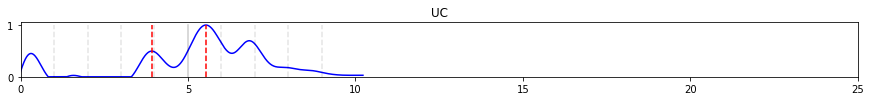


----------


****************************************


Patient: 20
Patient:  August 9, 2018, Pt F -- 3331a782-3057-401c-9c6a-2e0feb7abef2
Comment: Healthy, G4 P3. 38 wks GA.
Membranes intact, Cervix 3cm.
3 mod UC on file.
UC at 3 - 4mins, 8 - 9 mins, 13 - 14mins and 19 - 20 mins.
Minimal maternal movement only increased during UC. 
Lots of fetal movement during recording - disturbed fetal heart quality and registered as UC in areas not mentioned above.


Recording - Duration: 21m   Date: 1533820132  d2b5181b-8f79-4b5d-b7c6-1783510ff643

squelchMag: 0.00
Initial:
uc @  0.7   0.4- 1.1   width:   43 mag: 0.83
uc @  3.1   2.4- 3.8   width:   88 mag: 1.00
uc @  5.0   4.7- 5.3   width:   41 mag: 0.29
uc @  6.5   5.9- 7.0   width:   64 mag: 0.23
uc @  9.4   8.8-10.2   width:   82 mag: 0.51
uc @ 13.5  13.1-14.0   width:   54 mag: 0.27
uc @ 15.0  14.6-15.4   width:   48 mag: 0.59
uc @ 16.3  16.0-16.5   width:   30 mag: 0.06
uc @ 17.6  17.5-17.7   width:   11 mag: 0.01
uc @ 19.0  18.7-19.4   w

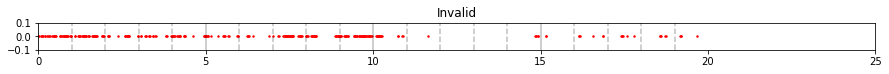

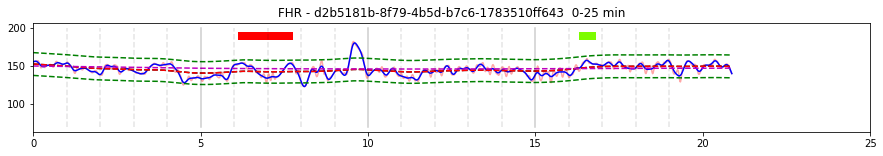

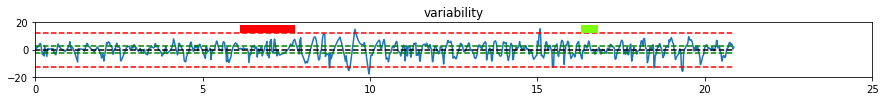

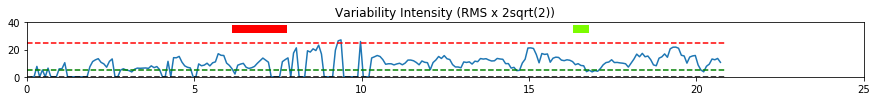

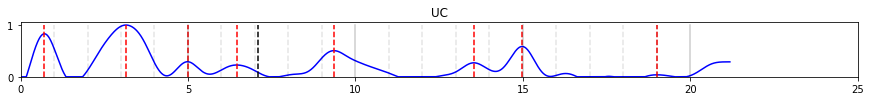

@ 7.08m : late_decel
                    18.8 bpm   dur:  84s (1.4min)   mag: 134.1 bpm   valid: 68%
                    tOnset:  51s   tRelease:  33s   span:  6.25 -  7.65 min
                    time below 70% drop: 36.0 sec
                    rms variability: 10 bpm
                    UC tAcme:  6.46m   lag:  37s
@16.53m : borderline_acceleration
                    11.6 bpm   dur:  15s (0.2min)   mag: 159.7 bpm   valid: 93%
                    tOnset:   6s   tRelease:   9s   span: 16.43 - 16.68 min

----------


****************************************



In [20]:
total_recordings = 0
for fhr, mask, ts, allUC, sigUC, tsUC, name in getRecordingsLowCostCTG(subset_recordings, catalog, 
                                                                       path, skip=skip_recordings):
    allIdx = []
    sustainedUC =[]
    if not isinstance(sigUC, type(None)) and len(sigUC) > 0:
        allIdx, allUC2 = findUC(sigUC, tsUC)
        
        if len(allIdx) > 0:
            base = np.percentile(sigUC, PARAMS_FILTER_UC['squelchPercentile'])
            if PARAMS_FILTER_UC['minThresh'] is None:
                squelchMag = base * PARAMS_FILTER_UC['squelchFactor']
            else:
                squelchMag = max(PARAMS_FILTER_UC['minThresh'],
                                 base * PARAMS_FILTER_UC['squelchFactor'])
            print 'squelchMag: {:0.2f}'.format(squelchMag)

            allUC, sustainedUC = filterArtfactsUC(sigUC, tsUC, allIdx, minMag=squelchMag, 
                                                  minWidth=PARAMS_FILTER_UC['minWidth'],
                                                  maxWidth=PARAMS_FILTER_UC['maxWidth'],
                                                  verbose=False)
    displayRecordingAll(fhr, mask, ts, allUC=allUC, filtUC=sigUC, tsUC=tsUC,
                        sustainedUC=sustainedUC,
                        allExtractorParams=FEATURE_EXTRACT_PARAMS, 
                        name=name, plotIncr = 20, showAltBaselines=True,
                        showFull=True, 
                        showVariability=True,
                        showBorderline=True,
                        showIndividualDecels=False) 
    
    total_recordings += 1
    if limit_recordings is not None and total_recordings >= limit_recordings:
        break